# Network Attack Pattern Visualization

A sophisticated data visualization analyzing temporal patterns in network attacks from honeypot data. This project demonstrates custom 3D rendering techniques to reveal attack timing and source patterns.

## Project Overview

This visualization analyzes real-world honeypot logs to identify and display malicious network activity patterns:

- **Objective**: Identify the most aggressive attack sources and their timing patterns
- **Data**: Network honeypot logs capturing attempted intrusions and malicious traffic
- **Method**: Custom 3D sphere bubble chart with gradient coloring
- **Output**: Interactive visualization showing attack distribution across 24-hour periods

### What This Visualization Shows:

The chart displays the **top 10 most aggressive source IPs** and maps when they attack throughout the day:

- **Y-axis**: Source IP addresses (ranked by total attack volume, most aggressive at top)
- **X-axis**: Hour of day (00:00 to 23:00)
- **Bubble size**: Number of attacks during that hour
- **Color gradient**: Attack intensity (darker = fewer attacks, brighter = more attacks)
- **3D spheres**: Custom rendering with shading and highlights for visual depth

This allows security analysts to quickly identify peak attack windows and persistent threat actors.

## Import Required Libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps

## Load and Prepare Data

Load honeypot attack logs and extract temporal features (hour of day) for analysis.

In [2]:
# Create a DataFrame from a CSV file. A sample csv file has been provided (Honeypot_Sample_Log.csv).
data = pd.read_csv("Honeypot_Sample_Log.csv", sep="\t", lineterminator='\r', dtype='string', encoding='utf8')

# Drop the last row. 
data = data[:-1]

# Extract hour from timestamp and convert to numeric
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour

# Display dataframe
display(data)

,timestamp,week day,year,month,hour,channel,source_ip,destination_port,protocol,city,country,country_code,Latitude,Longitude,asn_code,asn
0,2019-01-01 00:01:57.666,Tue,2019,01,0,cowrie.sessions,199.116.118.226,22,SSH,San Jose,United States,US,37.3881,-121.8756,46562,PERFORMIVE
1,2019-01-01 00:05:52.695,Tue,2019,01,0,dionaea.connections,139.162.121.251,3128,pcap,Tokyo,Japan,JP,35.6893,139.6899,63949,Linode - LLC
2,2019-01-01 00:06:07.156,Tue,2019,01,0,dionaea.connections,85.105.172.99,80,pcap,Istanbul,Turkey,TR,41.0197,28.9757,9121,Turk Telekom
3,2019-01-01 00:06:37.930,Tue,2019,01,0,cowrie.sessions,167.114.169.24,22,SSH,Montreal,Canada,CA,45.5063,-73.5794,16276,OVH SAS
4,2019-01-01 00:07:44.112,Tue,2019,01,0,cowrie.sessions,187.95.121.64,22,SSH,Curitiba,Brazil,BR,-25.5026,-49.2908,14868,COPEL Telecomunicacoes S.A.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520927,2019-12-16 13:56:51.515,Mon,2019,12,13,cowrie.sessions,218.92.0.141,22,SSH,Caolin,China,CN,32.0138,119.2863,4134,Chinanet
2520928,2019-12-16 13:58:13.777,Mon,2019,12,13,cowrie.sessions,218.92.0.158,22,SSH,Caolin,China,CN,32.0138,119.2863,4134,Chinanet
2520929,2019-12-16 13:58:29.053,Mon,2019,12,13,glastopf.events,223.199.21.25,80,https,Cenxi,China,CN,22.9234,110.9852,4134,Chinanet
2520930,2019-12-16 13:58:47.123,Mon,2019,12,13,cowrie.sessions,112.196.54.35,22,SSH,Mohali,India,IN,30.674,76.7249,17917,Quadrant Televentures Limited


## Attack Pattern Analysis & Visualization

This section identifies the most persistent attackers and visualizes their activity patterns across 24-hour periods.

The custom 3D sphere rendering creates visual depth through:
- **Multi-layered circles** with progressive shading
- **Highlight effects** simulating light reflection
- **Size scaling** proportional to attack volume
- **Color mapping** using a pastel viridis gradient


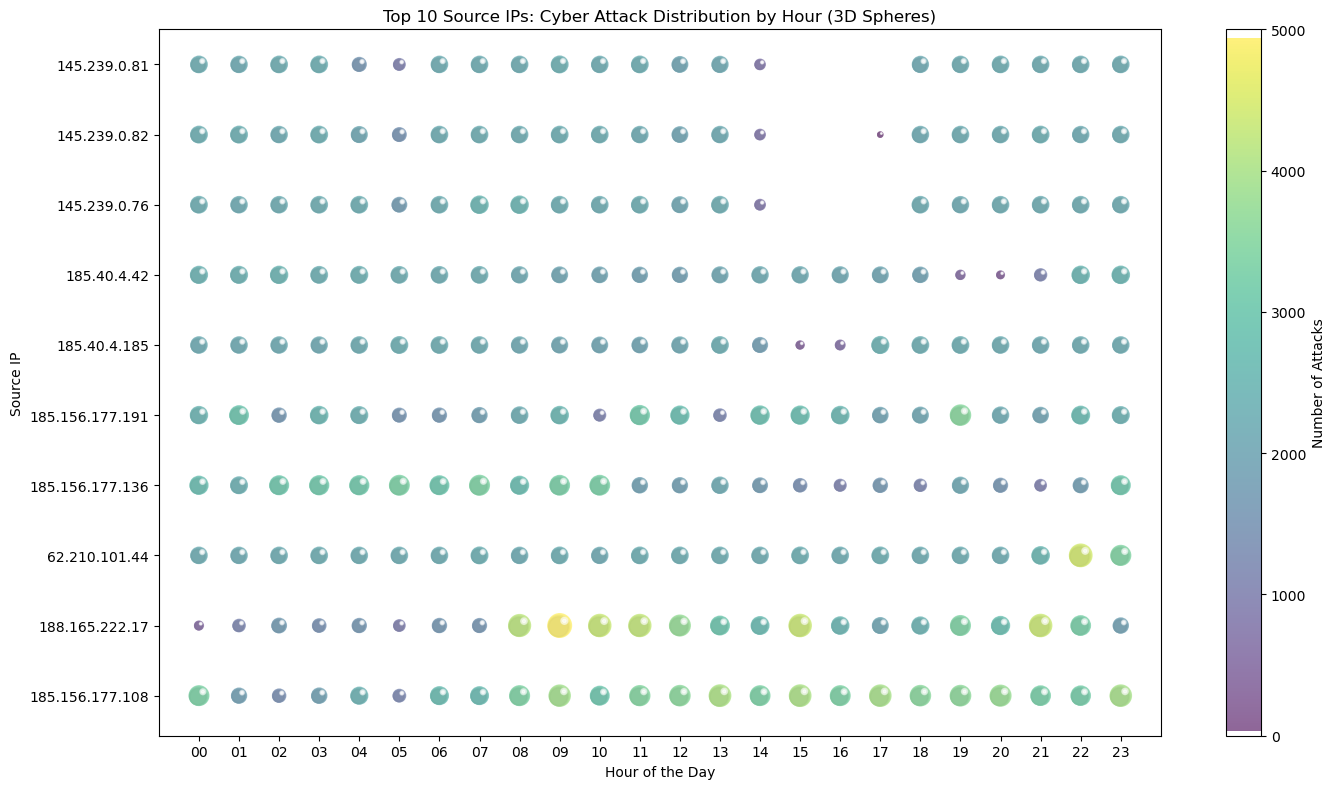

In [3]:
# identifies top N source IPs by attack frequency
def get_top_attacking_ips(data, top_n=10):
    grouped = data.groupby(["source_ip", "hour"]).size().reset_index(name="attack_count")
    top_ips = grouped.groupby("source_ip")["attack_count"].sum().nlargest(top_n).index
    filtered_data = grouped[grouped["source_ip"].isin(top_ips)]
    
    # sorts y-axis by aggressiveness
    filtered_data = filtered_data.copy()
    filtered_data["source_ip"] = pd.Categorical(
        filtered_data["source_ip"],
        categories=filtered_data.groupby("source_ip")["attack_count"].sum().sort_values(ascending=False).index,
        ordered=True
    )
    return filtered_data

# groups by source_ip 
filtered_data = get_top_attacking_ips(data, top_n=10)


# create a pastel version of viridis by blending it with white
viridis = colormaps.get_cmap("viridis")
pastel_viridis = ListedColormap(
    [(0.6 * r + 0.4, 0.6 * g + 0.4, 0.6 * b + 0.4) for r, g, b, _ in viridis(np.linspace(0, 1, 256))]
)

# sets spacing between source IPs for visual clarity
plt.figure(figsize=(14, 8)) 
ax = plt.gca()
spacing_factor = 1.75
unique_ips = filtered_data["source_ip"].cat.categories
ip_to_numeric = {ip: i * spacing_factor for i, ip in enumerate(unique_ips)}

# defines function to draw layered 3D-style spheres for each data point
# multi-layered circles with shading and highlights to simulate a 3D sphere effect
def draw_3d_sphere(ax, x, y, size, color, alpha=0.8):
    radius = np.sqrt(size) * 0.012
    for i in range(3):
        layer_radius = radius * (1 - i * 0.08)
        layer_alpha = alpha * (0.7 + 0.3 * (3 - i) / 3)
        offset = radius * 0.15 * i / 3
        darker = [c * (0.85 + 0.15 * (3 - i) / 3) for c in color[:3]]
        ax.add_patch(Circle((x - offset, y - offset), layer_radius, color=darker, alpha=layer_alpha, zorder=10+i))
    shine_x, shine_y = x + radius * 0.4, y + radius * 0.4
    shine_r = radius * 0.3
    ax.add_patch(Circle((shine_x, shine_y), shine_r, color="white", alpha=0.5, zorder=20))
    ax.add_patch(Circle((shine_x, shine_y), shine_r * 0.5, color="white", alpha=0.7, zorder=21))

"""
Parameters:
ax (matplotlib.axes.Axes): The axis to draw on.
x (float): X-coordinate (hour).
y (float): Y-coordinate (source IP as numeric position).
size (float): Size of the sphere.
color (tuple): RGB or RGBA color for the sphere.
alpha (float): Opacity level of the sphere layers (default is 0.8).
"""

# maps attack counts to sphere sizes and colors for plotting
min_size, max_size = 30, 600
min_val, max_val = filtered_data["attack_count"].min(), filtered_data["attack_count"].max()
norm = plt.Normalize(min_val, max_val)

for _, row in filtered_data.iterrows():
    x = row["hour"]
    y = ip_to_numeric[row["source_ip"]]
    count = row["attack_count"]
    size = min_size + (count - min_val) / (max_val - min_val) * (max_size - min_size) if max_val > min_val else min_size
    color = pastel_viridis(norm(count))
    draw_3d_sphere(ax, x, y, size, color)

# configures axis labels, ticks, limits, and chart title
ax.set_xticks(range(24))
ax.set_xticklabels([f"{i:02}" for i in range(24)])
ax.set_yticks([i * spacing_factor for i in range(len(unique_ips))])
ax.set_yticklabels(unique_ips)
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Source IP")
ax.set_title("Top 10 Source IPs: Cyber Attack Distribution by Hour (3D Spheres)")
ax.invert_yaxis()
ax.set_xlim(-1.0, 24)
ax.set_ylim(-1.0, (len(unique_ips) - 0.5) * spacing_factor)
ax.set_aspect("equal", adjustable="box")
ax.grid(False)

# adds colorbar to the right side to represent attack count gradient
sm = plt.cm.ScalarMappable(cmap=pastel_viridis, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.65) 
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Number of Attacks")
cbar.set_ticks([0, 1000, 2000, 3000, 4000, 5000])

# applies layout adjustments and renders the final plot
plt.tight_layout()
plt.show()


## Analysis Insights

This visualization enables security teams to:

### Identify Temporal Patterns
- **Peak attack hours**: Concentrated malicious activity during specific time windows
- **Off-hours targeting**: Attacks timed for reduced security monitoring
- **Sustained campaigns**: IPs maintaining activity across multiple hours

### Prioritize Threat Response
- **Volume-based ranking**: Most aggressive sources appear at the top
- **Intensity indicators**: Bubble size and color reveal attack severity
- **Pattern recognition**: Repeated timing patterns suggest coordinated attacks

### Communicate Findings
The 3D sphere rendering provides an intuitive, visually compelling way to present complex temporal security data to both technical teams and executive stakeholders.

---

**Technical Implementation**: Custom matplotlib rendering with geometric calculations for sphere layering, color gradient mapping, and spatial positioning optimization.